# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [281]:
# Importing important libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import ast
from scipy import stats
from sklearn import preprocessing as p
from collections import Counter
from sklearn.preprocessing import Imputer
from sklearn.decomposition import PCA
import matplotlib




# library for data visualization
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [282]:
# Loading the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', delimiter=';')

# Loading the feature summary data.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', delimiter = ';')

In [283]:
# Checking the number of rows and columns.
azdias.head()


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [284]:
feat_info.head(10)

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]
5,FINANZ_SPARER,person,ordinal,[-1]
6,FINANZ_VORSORGER,person,ordinal,[-1]
7,FINANZ_ANLEGER,person,ordinal,[-1]
8,FINANZ_UNAUFFAELLIGER,person,ordinal,[-1]
9,FINANZ_HAUSBAUER,person,ordinal,[-1]


In [285]:
azdias.info() # getting information of the dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
AGER_TYP                 891221 non-null int64
ALTERSKATEGORIE_GROB     891221 non-null int64
ANREDE_KZ                891221 non-null int64
CJT_GESAMTTYP            886367 non-null float64
FINANZ_MINIMALIST        891221 non-null int64
FINANZ_SPARER            891221 non-null int64
FINANZ_VORSORGER         891221 non-null int64
FINANZ_ANLEGER           891221 non-null int64
FINANZ_UNAUFFAELLIGER    891221 non-null int64
FINANZ_HAUSBAUER         891221 non-null int64
FINANZTYP                891221 non-null int64
GEBURTSJAHR              891221 non-null int64
GFK_URLAUBERTYP          886367 non-null float64
GREEN_AVANTGARDE         891221 non-null int64
HEALTH_TYP               891221 non-null int64
LP_LEBENSPHASE_FEIN      886367 non-null float64
LP_LEBENSPHASE_GROB      886367 non-null float64
LP_FAMILIE_FEIN          886367 non-null float64
LP_FAMILIE_GROB          886367 n

In [286]:
azdias.describe()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,...,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,794005.000000,794005.000000,794005.00000
mean,-0.358435,2.777398,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,...,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.167854,5.293002,3.07222
std,1.198724,1.068775,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,...,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,1.002376,2.303739,1.36298
min,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.00000
25%,-1.000000,2.000000,1.000000,2.000000,2.000000,1.000000,3.000000,2.000000,2.000000,2.000000,...,1.000000,2.000000,1.000000,0.000000,1.000000,3.000000,3.000000,3.000000,4.000000,2.00000
50%,-1.000000,3.000000,2.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,2.000000,3.000000,2.000000,1.000000,1.000000,4.000000,3.000000,3.000000,5.000000,3.00000
75%,-1.000000,4.000000,2.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,4.000000,...,3.000000,3.000000,2.000000,1.000000,3.000000,4.000000,4.000000,4.000000,7.000000,4.00000
max,3.000000,9.000000,2.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,4.000000,4.000000,3.000000,2.000000,5.000000,5.000000,5.000000,9.000000,9.000000,9.00000


In [287]:
feat_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 4 columns):
attribute             85 non-null object
information_level     85 non-null object
type                  85 non-null object
missing_or_unknown    85 non-null object
dtypes: object(4)
memory usage: 2.7+ KB


In [288]:
feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [289]:
feat_info.describe()

,attribute,information_level,type,missing_or_unknown
count,85,85,85,85
unique,85,9,5,9
top,PRAEGENDE_JUGENDJAHRE,person,ordinal,[-1]
freq,1,43,49,26


In [290]:
print('azdias shape :', azdias.shape)
print('feat_info shape :', feat_info.shape)

azdias shape : (891221, 85)
feat_info shape : (85, 4)


In [291]:
for i in range(len(feat_info)):
    if feat_info['type'][i] == "numeric":
        print(feat_info['attribute'][i])
        print(feat_info['missing_or_unknown'][i])

GEBURTSJAHR
[0]
ANZ_PERSONEN
[]
ANZ_TITEL
[]
ANZ_HAUSHALTE_AKTIV
[0]
ANZ_HH_TITEL
[]
MIN_GEBAEUDEJAHR
[0]
KBA13_ANZAHL_PKW
[]


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [292]:
# Checking missing or unknown  values and convert them to NaN.
feat_info['missing_or_unknown'] = feat_info['missing_or_unknown'].apply(lambda x: x[1:-1].split(','))


In [293]:
feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1, 0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1, 0, 9]"
2,ANREDE_KZ,person,categorical,"[-1, 0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [294]:
# Checking missing or unknown  values and convert them to NaN.
for attrib, missing_values in zip(feat_info['attribute'], feat_info['missing_or_unknown']):
    if missing_values[0] != '':
        for value in missing_values:
            if value.isnumeric() or value.lstrip('-').isnumeric():
                value = int(value)
            azdias.loc[azdias[attrib] == value, attrib] = np.nan

In [295]:
# Perform an assessment of how much missing data there is
# in each column of the dataset.
attribute = []
num_nan = [] 
for k in azdias.columns:
    attribute.append(k)
    num_nan.append(azdias[k].isnull().sum()/len(azdias))

data_nan = pd.DataFrame({'attribute': attribute, 'Number of nan': num_nan })

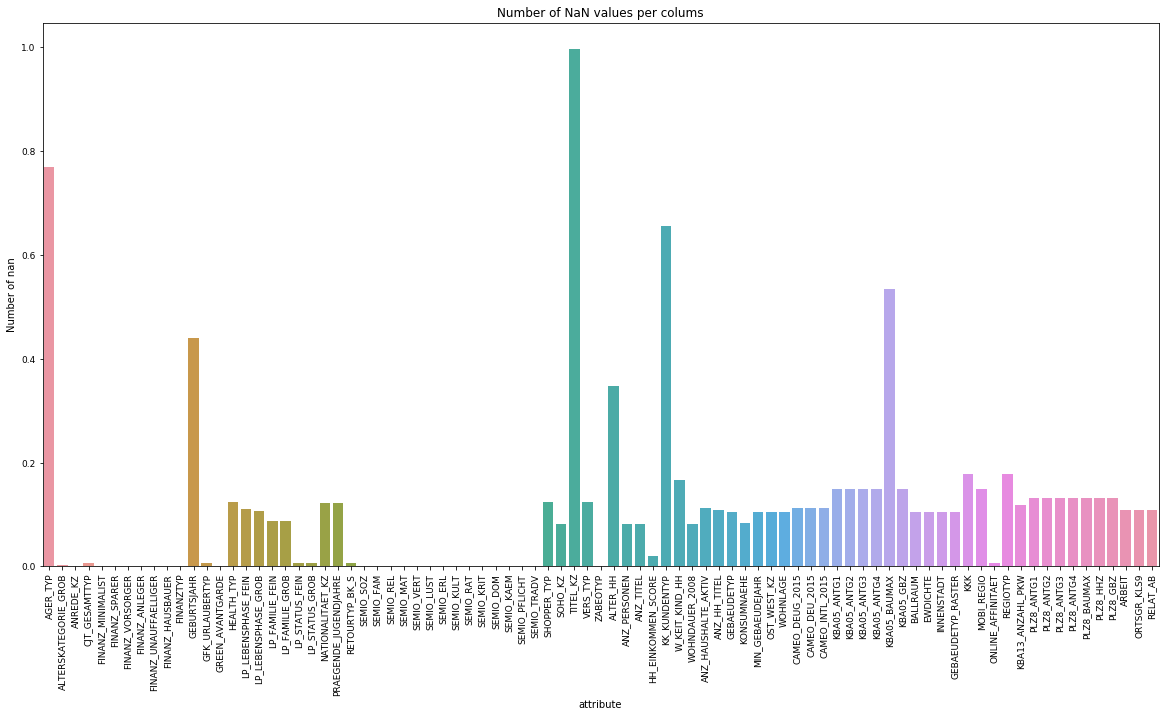

In [296]:
# Investigate patterns in the amount of missing data in each column.
plt.figure(figsize=(20, 10))
sns.barplot(x="attribute", y="Number of nan", orient='v', data=data_nan)
plt.xticks(rotation=90)
matplotlib.rc('xtick', labelsize=9)     
matplotlib.rc('ytick', labelsize=9)
plt.title('Number of NaN values per colums')
plt.show()


In [297]:
outliers = data_nan[data_nan['Number of nan'] > 0.2]['attribute'].values.tolist()
outliers

['AGER_TYP',
 'GEBURTSJAHR',
 'TITEL_KZ',
 'ALTER_HH',
 'KK_KUNDENTYP',
 'KBA05_BAUMAX']

In [298]:
# The following columns have no-null values. In the above cell,
#the percentage of non-missing values is 1.00 for some columns.
#Here we got exactly those columns as output with non-missing values.
clean_data = data_nan[data_nan['Number of nan'] == 0]['attribute'].values.tolist()
clean_data

['ANREDE_KZ',
 'FINANZ_MINIMALIST',
 'FINANZ_SPARER',
 'FINANZ_VORSORGER',
 'FINANZ_ANLEGER',
 'FINANZ_UNAUFFAELLIGER',
 'FINANZ_HAUSBAUER',
 'FINANZTYP',
 'GREEN_AVANTGARDE',
 'SEMIO_SOZ',
 'SEMIO_FAM',
 'SEMIO_REL',
 'SEMIO_MAT',
 'SEMIO_VERT',
 'SEMIO_LUST',
 'SEMIO_ERL',
 'SEMIO_KULT',
 'SEMIO_RAT',
 'SEMIO_KRIT',
 'SEMIO_DOM',
 'SEMIO_KAEM',
 'SEMIO_PFLICHT',
 'SEMIO_TRADV',
 'ZABEOTYP']

In [299]:
# Remove the outlier columns from the dataset.
azdias =  azdias.drop(outliers, axis=1)

In [300]:
azdias['Number_NaN'] = azdias.apply(lambda row: row.isnull().sum(), axis=1)

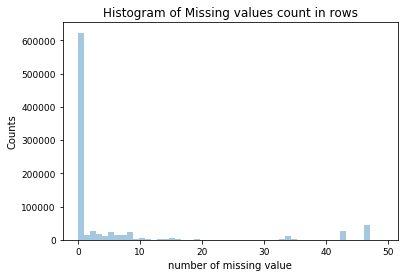

In [301]:
sns.distplot(azdias['Number_NaN'], kde=False)
plt.xlabel('number of missing value')
plt.ylabel('Counts')
plt.title('Histogram of Missing values count in rows')
plt.show()

In [302]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
azdias_below = azdias[azdias['Number_NaN'] < 10]
azdias_above = azdias[azdias['Number_NaN'] >= 10]

In [303]:
print(len(azdias_below))
print(len(azdias_above))
print(len(azdias_below)/(len(azdias_below)+len(azdias_above)))

774743
116478
0.8693051442908101


In [304]:
def data_vis(data_1, data_2, clm = ''):
    plt.figure(figsize=(20, 10))
    plt.subplot(1, 2, 1)
    sns.countplot(x=clm, data=data_1)
    plt.subplot(1, 2, 2)
    sns.countplot(x=clm, data=data_2)
    plt.show()

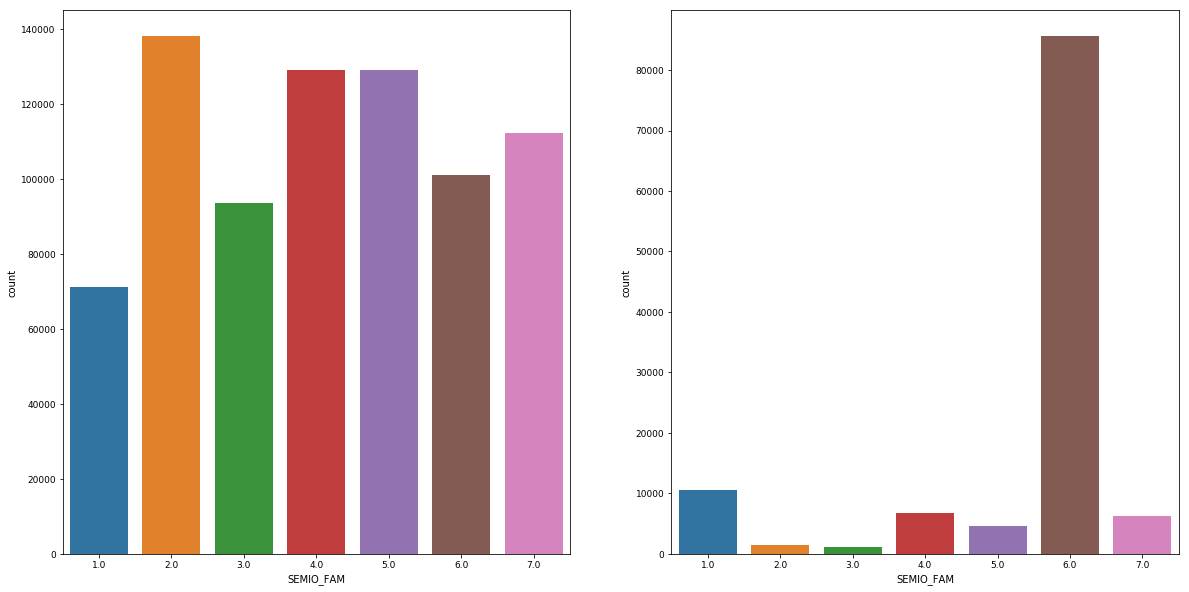

In [305]:
data_vis(azdias_below, azdias_above, clm=clean_data[10])

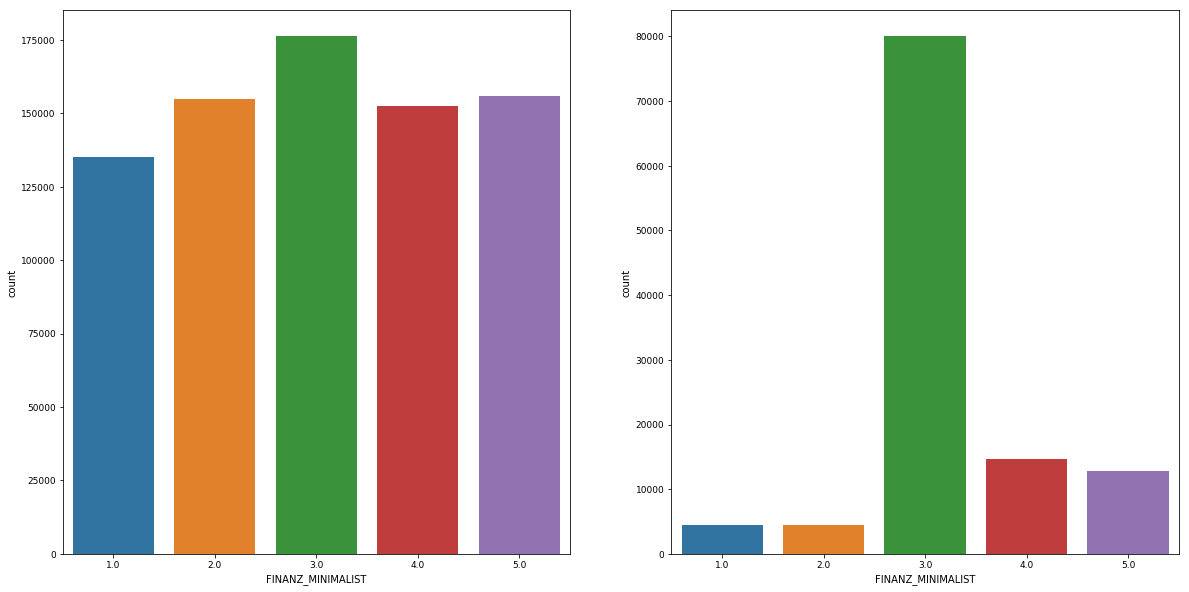

In [306]:
data_vis(azdias_below, azdias_above, clm=clean_data[1])

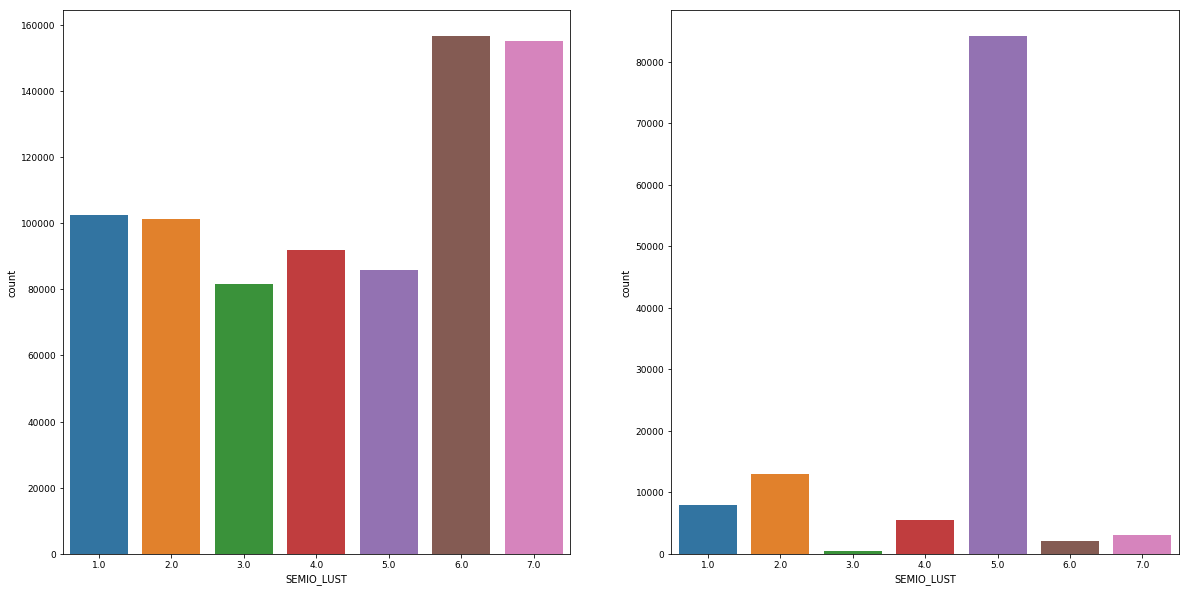

In [307]:
data_vis(azdias_below, azdias_above, clm=clean_data[14])

In [308]:
## removing lines that contain more than 10 missing values
azdias = azdias[azdias['Number_NaN'] < 10]

In [309]:
azdias.head(10) #missing values replaced with NaN

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,Number_NaN
1,1.0,2.0,5.0,1.0,5.0,2.0,5.0,4.0,5.0,1.0,...,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0,0
2,3.0,2.0,3.0,1.0,4.0,1.0,2.0,3.0,5.0,1.0,...,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0,0
3,4.0,2.0,2.0,4.0,2.0,5.0,2.0,1.0,2.0,6.0,...,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0,7
4,3.0,1.0,5.0,4.0,3.0,4.0,1.0,3.0,2.0,5.0,...,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0,0
5,1.0,2.0,2.0,3.0,1.0,5.0,2.0,2.0,5.0,2.0,...,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0,0
6,2.0,2.0,5.0,1.0,5.0,1.0,5.0,4.0,3.0,4.0,...,3.0,1.0,0.0,1.0,5.0,5.0,4.0,6.0,3.0,0
7,1.0,1.0,3.0,3.0,3.0,4.0,1.0,3.0,2.0,5.0,...,3.0,1.0,0.0,1.0,4.0,4.0,2.0,5.0,2.0,0
8,3.0,1.0,3.0,4.0,4.0,2.0,4.0,2.0,2.0,6.0,...,3.0,2.0,1.0,1.0,3.0,3.0,2.0,4.0,3.0,0
9,3.0,2.0,4.0,2.0,4.0,2.0,3.0,5.0,4.0,1.0,...,3.0,2.0,1.0,1.0,3.0,3.0,2.0,3.0,1.0,0
10,3.0,2.0,1.0,2.0,2.0,5.0,3.0,1.0,5.0,6.0,...,4.0,2.0,0.0,2.0,3.0,3.0,4.0,6.0,5.0,0


In [310]:
print(azdias.shape)

(774743, 80)


In [311]:
for i in range(azdias.shape[1]):
    if azdias.iloc[:,i].isnull().sum() == 0:
        print(f"{azdias.columns[i]}")

ANREDE_KZ
CJT_GESAMTTYP
FINANZ_MINIMALIST
FINANZ_SPARER
FINANZ_VORSORGER
FINANZ_ANLEGER
FINANZ_UNAUFFAELLIGER
FINANZ_HAUSBAUER
FINANZTYP
GFK_URLAUBERTYP
GREEN_AVANTGARDE
LP_STATUS_FEIN
LP_STATUS_GROB
RETOURTYP_BK_S
SEMIO_SOZ
SEMIO_FAM
SEMIO_REL
SEMIO_MAT
SEMIO_VERT
SEMIO_LUST
SEMIO_ERL
SEMIO_KULT
SEMIO_RAT
SEMIO_KRIT
SEMIO_DOM
SEMIO_KAEM
SEMIO_PFLICHT
SEMIO_TRADV
SOHO_KZ
ZABEOTYP
ANZ_PERSONEN
ANZ_TITEL
HH_EINKOMMEN_SCORE
WOHNDAUER_2008
GEBAEUDETYP
MIN_GEBAEUDEJAHR
OST_WEST_KZ
WOHNLAGE
ONLINE_AFFINITAET
Number_NaN


In [312]:
data={}
for i in range(azdias.shape[1]):
    if azdias.iloc[:, i].isnull().sum() > 0:
        print(f"{azdias.columns[i]}:  {azdias.iloc[:,i].isnull().sum()}")
        data[azdias.columns[i]] = azdias.iloc[:, i].isnull().sum()

ALTERSKATEGORIE_GROB:  2596
HEALTH_TYP:  33420
LP_LEBENSPHASE_FEIN:  41755
LP_LEBENSPHASE_GROB:  39088
LP_FAMILIE_FEIN:  24478
LP_FAMILIE_GROB:  24478
NATIONALITAET_KZ:  30824
PRAEGENDE_JUGENDJAHRE:  25502
SHOPPER_TYP:  33420
VERS_TYP:  33420
W_KEIT_KIND_HH:  55257
ANZ_HAUSHALTE_AKTIV:  5651
ANZ_HH_TITEL:  3163
KONSUMNAEHE:  51
CAMEO_DEUG_2015:  3456
CAMEO_DEU_2015:  3456
CAMEO_INTL_2015:  3456
KBA05_ANTG1:  24201
KBA05_ANTG2:  24201
KBA05_ANTG3:  24201
KBA05_ANTG4:  24201
KBA05_GBZ:  24201
BALLRAUM:  526
EWDICHTE:  526
INNENSTADT:  526
GEBAEUDETYP_RASTER:  5
KKK:  54136
MOBI_REGIO:  24201
REGIOTYP:  54136
KBA13_ANZAHL_PKW:  5483
PLZ8_ANTG1:  7783
PLZ8_ANTG2:  7783
PLZ8_ANTG3:  7783
PLZ8_ANTG4:  7783
PLZ8_BAUMAX:  7783
PLZ8_HHZ:  7783
PLZ8_GBZ:  7783
ARBEIT:  3936
ORTSGR_KLS9:  3850
RELAT_AB:  3936


In [313]:
# Perform an assessment of how much missing data there is in each column of the dataset.
missing_data={}
for i in range(azdias.shape[1]):
    if azdias.iloc[:, i].isnull().sum() > 0:
        print(f"{azdias.columns[i]}:  {azdias.iloc[:,i].isnull().sum()}")

ALTERSKATEGORIE_GROB:  2596
HEALTH_TYP:  33420
LP_LEBENSPHASE_FEIN:  41755
LP_LEBENSPHASE_GROB:  39088
LP_FAMILIE_FEIN:  24478
LP_FAMILIE_GROB:  24478
NATIONALITAET_KZ:  30824
PRAEGENDE_JUGENDJAHRE:  25502
SHOPPER_TYP:  33420
VERS_TYP:  33420
W_KEIT_KIND_HH:  55257
ANZ_HAUSHALTE_AKTIV:  5651
ANZ_HH_TITEL:  3163
KONSUMNAEHE:  51
CAMEO_DEUG_2015:  3456
CAMEO_DEU_2015:  3456
CAMEO_INTL_2015:  3456
KBA05_ANTG1:  24201
KBA05_ANTG2:  24201
KBA05_ANTG3:  24201
KBA05_ANTG4:  24201
KBA05_GBZ:  24201
BALLRAUM:  526
EWDICHTE:  526
INNENSTADT:  526
GEBAEUDETYP_RASTER:  5
KKK:  54136
MOBI_REGIO:  24201
REGIOTYP:  54136
KBA13_ANZAHL_PKW:  5483
PLZ8_ANTG1:  7783
PLZ8_ANTG2:  7783
PLZ8_ANTG3:  7783
PLZ8_ANTG4:  7783
PLZ8_BAUMAX:  7783
PLZ8_HHZ:  7783
PLZ8_GBZ:  7783
ARBEIT:  3936
ORTSGR_KLS9:  3850
RELAT_AB:  3936


In [314]:
azdias.count() / len(azdias)  #the percentage of non-missing values in each column.

ALTERSKATEGORIE_GROB     0.996649
ANREDE_KZ                1.000000
CJT_GESAMTTYP            1.000000
FINANZ_MINIMALIST        1.000000
FINANZ_SPARER            1.000000
FINANZ_VORSORGER         1.000000
FINANZ_ANLEGER           1.000000
FINANZ_UNAUFFAELLIGER    1.000000
FINANZ_HAUSBAUER         1.000000
FINANZTYP                1.000000
GFK_URLAUBERTYP          1.000000
GREEN_AVANTGARDE         1.000000
HEALTH_TYP               0.956863
LP_LEBENSPHASE_FEIN      0.946105
LP_LEBENSPHASE_GROB      0.949547
LP_FAMILIE_FEIN          0.968405
LP_FAMILIE_GROB          0.968405
LP_STATUS_FEIN           1.000000
LP_STATUS_GROB           1.000000
NATIONALITAET_KZ         0.960214
PRAEGENDE_JUGENDJAHRE    0.967083
RETOURTYP_BK_S           1.000000
SEMIO_SOZ                1.000000
SEMIO_FAM                1.000000
SEMIO_REL                1.000000
SEMIO_MAT                1.000000
SEMIO_VERT               1.000000
SEMIO_LUST               1.000000
SEMIO_ERL                1.000000
SEMIO_KULT    

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [315]:
azdias.count().tail() # the number of non-missing values for each column or row.

PLZ8_GBZ       766960
ARBEIT         770807
ORTSGR_KLS9    770893
RELAT_AB       770807
Number_NaN     774743
dtype: int64

In [316]:
azdias.isnull().sum().sum()

690218

In [317]:
feat_info.isnull().sum()

attribute             0
information_level     0
type                  0
missing_or_unknown    0
dtype: int64

In [318]:
# Assessing categorical variables which are binary, multi-level, and where re-encoding is necessary?
attribute_info  = feat_info[feat_info['attribute'] != outliers[0]]

for k in range(len(outliers) - 1):
    attribute_info = attribute_info[attribute_info['attribute'] != outliers[k+1]] 
    
categorical_variables = attribute_info[attribute_info['type'] == 'categorical']['attribute'].values.tolist()

In [319]:
binary_variable = []
multi_levels = []
binary_num_variable= []
re_encoded_variable = []
for k in categorical_variables:
    if len(azdias[k].value_counts()) == 2:
        if type(azdias[k].value_counts().index[0]) == str:
            binary_variable.append(k)
        else:
            binary_num_variable.append(k)
    else:
        multi_levels.append(k)

In [320]:
binary_variable 

['OST_WEST_KZ']

In [321]:
multi_levels

['CJT_GESAMTTYP',
 'FINANZTYP',
 'GFK_URLAUBERTYP',
 'LP_FAMILIE_FEIN',
 'LP_FAMILIE_GROB',
 'LP_STATUS_FEIN',
 'LP_STATUS_GROB',
 'NATIONALITAET_KZ',
 'SHOPPER_TYP',
 'ZABEOTYP',
 'GEBAEUDETYP',
 'CAMEO_DEUG_2015',
 'CAMEO_DEU_2015']

In [322]:
binary_num_variable

['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'VERS_TYP']

In [323]:
re_encoded_variable

[]

In [324]:
# Re-encoding OST_WEST_KZ parameter
azdias['NEW_OST_WEST_KZ'] = azdias['OST_WEST_KZ']
mymap = {'W': 0, 'O': 1}
azdias= azdias.replace({'NEW_OST_WEST_KZ': mymap})

# Checking whether re-encoding is working or not?
azdias.loc[101:102,['OST_WEST_KZ', 'NEW_OST_WEST_KZ']]

,OST_WEST_KZ,NEW_OST_WEST_KZ
101,W,0
102,W,0


In [325]:
azdias = azdias.drop(multi_levels, axis=1)

In [326]:
azdias = azdias.drop('OST_WEST_KZ', axis=1)

In [327]:
azdias.shape

(774743, 67)

#### Discussion 1.1.2: Assess Missing Data in Each Column

(Double click this cell and replace this text with your own text, reporting your observations regarding the amount of missing data in each column. Are there any patterns in missing values? Which columns were removed from the dataset?)

Answer: From the bar graph plotted above, the majority of columns contain a percentage of missing data that lies between 10 and 20 percent, except for the 'AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP' and 'KBA05_BAUMAX' variables that have more than 35 % percentage of missing data. So I decided to remove variables with more than 30% missing values.
Yes, the data with lots of missing values are qualitatively different from data with few or no missing values. I calculated the outliers on the basis of missing data and histogram plot. The following columns removed from the dataset: 
['CJT_GESAMTTYP',
 'FINANZTYP',
 'GFK_URLAUBERTYP',
 'LP_FAMILIE_FEIN',
 'LP_FAMILIE_GROB',
 'LP_STATUS_FEIN',
 'LP_STATUS_GROB',
 'NATIONALITAET_KZ',
 'SHOPPER_TYP',
 'ZABEOTYP',
 'GEBAEUDETYP',
 'CAMEO_DEUG_2015',
 'CAMEO_DEU_2015'']
There is no clear pattern between the outliers but the number of missing values are same between some variables. For example: 
1. PLZ8_ANTG1:  7783
2. PLZ8_ANTG2:  7783
3. PLZ8_ANTG3:  7783
4. PLZ8_ANTG4:  7783
5. PLZ8_BAUMAX:  7783
6. PLZ8_HHZ:  7783
7. PLZ8_GBZ:  7783


1. KBA05_ANTG1:  24201
2. KBA05_ANTG2:  24201
3. KBA05_ANTG3:  24201
4. KBA05_ANTG4:  24201
5. KBA05_GBZ:  24201


### The following columns have no-null values:
1. AGER_TYP
2. ALTERSKATEGORIE_GROB
3. ANREDE_KZ
4. FINANZ_MINIMALIST
5. FINANZ_SPARER
6. FINANZ_VORSORGER
7. FINANZ_ANLEGER
8. FINANZ_UNAUFFAELLIGER
9. FINANZ_HAUSBAUER
10. FINANZTYP
11. GEBURTSJAHR
12. GREEN_AVANTGARDE
13. HEALTH_TYP
14. NATIONALITAET_KZ
15. PRAEGENDE_JUGENDJAHRE
16. SEMIO_SOZ
17. SEMIO_FAM
18. SEMIO_REL
19. SEMIO_MAT
20. SEMIO_VERT
21. SEMIO_LUST
22. SEMIO_ERL
23. SEMIO_KULT
24. SEMIO_RAT
25. SEMIO_KRIT
26. SEMIO_DOM
27. SEMIO_KAEM
28. SEMIO_PFLICHT
29. SEMIO_TRADV
30. SHOPPER_TYP
31. VERS_TYP
32. ZABEOTYP


#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

#### Discussion 1.1.3: Assess Missing Data in Each Row

(Double-click this cell and replace this text with your own text, reporting your observations regarding missing data in rows. Are the data with lots of missing values are qualitatively different from data with few or no missing values?
From the bar graph titled as "Histogram of Missing value counts" in each row we can see that most of rows contains less than than 10 missing values. So, I decided to set  the threshold value  to 10 missing values and  created two subsets from the orginal data with the one with rows containing more  than 10 missing values and the second one with rows containing less than 10 missing values.

I plotted the countplot for 3 columns that are having no missing values and noticed the superiority of one value/column in the data with more than 10 missing values. So, I just removed that columns containing more than 10 missing values.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [328]:
# How many features are there of each data type?
feat_info.groupby(by="type").size()


type
categorical    21
interval        1
mixed           7
numeric         7
ordinal        49
dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

#### Discussion 1.2.1: Re-Encode Categorical Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding categorical features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

### Answer:  
First I accessed all the categorical variables and found that it contains multi-level and binary variables. I used one hot encoding to convert categorical variable into dummy/indicator variables. During feature scaling, I was getting the error: Cannot Convert String to Float. So, I converted 'W' and 'O'into 0 and 1 respectively . I kept the 'OST_WEST_KZ'binary variable with numeric values and dropped all the non-binary categorical variables.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [329]:
mixed_variables = []
for i in range(feat_info.shape[0]):
    if feat_info['type'][i] == 'mixed':
        mixed_variables.append(feat_info['attribute'][i])
    
print(f"Mixed type variables:\n{mixed_variables}\n")


Mixed type variables:
['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'PRAEGENDE_JUGENDJAHRE', 'WOHNLAGE', 'CAMEO_INTL_2015', 'KBA05_BAUMAX', 'PLZ8_BAUMAX']



In [330]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
azdias["PRAEGENDE_JUGENDJAHRE"].value_counts(dropna=False)

 14.0    177574
 8.0     137903
 10.0     83394
 5.0      83112
 3.0      52758
 15.0     40803
 11.0     34385
 9.0      32939
NaN       25502
 6.0      25311
 12.0     23925
 4.0      20185
 1.0      20106
 2.0       7387
 13.0      5520
 7.0       3939
Name: PRAEGENDE_JUGENDJAHRE, dtype: int64

In [331]:
# Feature engineering: "PRAEGENDE_JUGENDJAHRE" 

pragende_decade = {1: 20, 2: 30, 3: 30, 4: 30, 5: 30,\
                   6: 40, 7: 40, 8: 40, 9: 50, 10: 50,\
                   11: 50, 12: 60, 13: 60, 14: 60, 15: 60, np.nan : np.nan}   # ordinal variables

azdias["PRAEGENDE_JUGENDJAHRE_Decade"] = azdias['PRAEGENDE_JUGENDJAHRE']
azdias["PRAEGENDE_JUGENDJAHRE_Decade"] = azdias["PRAEGENDE_JUGENDJAHRE_Decade"].map(pragende_decade)


In [332]:
azdias["PRAEGENDE_JUGENDJAHRE_Decade"].value_counts( dropna=False)

 60.0    247822
 40.0    167153
 30.0    163442
 50.0    150718
NaN       25502
 20.0     20106
Name: PRAEGENDE_JUGENDJAHRE_Decade, dtype: int64

In [333]:
pragende_movement = {1: 0.0, 2: 0.0, 3: 0.0, 4: 1.0, 5: 1.0, 6: 1.0,\
                 7: 0.0, 8: 0.0, 9: 0.0, 10: 1.0, 11: 0.0, 12: 1.0,\
                 13: 1.0, 14: 1.0, 15: 0.0, np.nan : np.nan}

azdias["PRAEGENDE_JUGENDJAHRE_Movement"] = azdias['PRAEGENDE_JUGENDJAHRE']
azdias['PRAEGENDE_JUGENDJAHRE_Movement'] = azdias["PRAEGENDE_JUGENDJAHRE_Movement"].map(pragende_movement)

In [334]:
azdias["PRAEGENDE_JUGENDJAHRE_Movement"].value_counts( dropna=False)

 1.0    419021
 0.0    330220
NaN      25502
Name: PRAEGENDE_JUGENDJAHRE_Movement, dtype: int64

In [335]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
azdias["CAMEO_INTL_2015"].value_counts( dropna=False)

51     132086
41      90430
24      88559
14      60994
43      55429
54      44745
25      38587
22      31990
45      25610
13      25477
23      24111
55      23440
52      20258
34      18111
31      17721
15      16645
44      14502
12      12795
35      10139
32      10087
33       9571
NaN      3456
Name: CAMEO_INTL_2015, dtype: int64

In [336]:
#Feature engineering:"CAMEO_INTL_2015" 

azdias["CAMEO_INTL_2015_Wealth"] = azdias["CAMEO_INTL_2015"].apply(lambda x : \
                                                                x if type(x) == float else int(x[0]))

In [337]:
azdias["CAMEO_INTL_2015_Wealth"].value_counts(dropna=False)

 5.0    220529
 4.0    185971
 2.0    183247
 1.0    115911
 3.0     65629
NaN       3456
Name: CAMEO_INTL_2015_Wealth, dtype: int64

In [338]:
 azdias["CAMEO_INTL_2015_Lifestage"] = azdias["CAMEO_INTL_2015"].apply(lambda x :\
                                                x if type(x) == float else int(x[1]))

In [339]:
azdias["CAMEO_INTL_2015_Lifestage"].value_counts(dropna=False)

 1.0    240237
 4.0    226911
 3.0    114588
 5.0    114421
 2.0     75130
NaN       3456
Name: CAMEO_INTL_2015_Lifestage, dtype: int64

In [340]:
azdias.shape

(774743, 71)

In [341]:
#azdias =  azdias.drop(['Number_NaN'], axis=1)


In [342]:
mixed_attribute = [k  for k in feat_info[feat_info['type'] == 'mixed']['attribute'].values.tolist() if \
                  k not in outliers]

In [343]:
mixed_attribute

['LP_LEBENSPHASE_FEIN',
 'LP_LEBENSPHASE_GROB',
 'PRAEGENDE_JUGENDJAHRE',
 'WOHNLAGE',
 'CAMEO_INTL_2015',
 'PLZ8_BAUMAX']

In [344]:
azdias =  azdias.drop(mixed_attribute, axis=1)

In [345]:
azdias.head(5)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,Number_NaN,NEW_OST_WEST_KZ,PRAEGENDE_JUGENDJAHRE_Decade,PRAEGENDE_JUGENDJAHRE_Movement,CAMEO_INTL_2015_Wealth,CAMEO_INTL_2015_Lifestage
1,1.0,2.0,1.0,5.0,2.0,5.0,4.0,5.0,0,3.0,...,4.0,3.0,5.0,4.0,0,0,60.0,1.0,5.0,1.0
2,3.0,2.0,1.0,4.0,1.0,2.0,3.0,5.0,1,3.0,...,4.0,3.0,5.0,2.0,0,0,60.0,0.0,2.0,4.0
3,4.0,2.0,4.0,2.0,5.0,2.0,1.0,2.0,0,2.0,...,4.0,2.0,3.0,3.0,7,0,40.0,0.0,1.0,2.0
4,3.0,1.0,4.0,3.0,4.0,1.0,3.0,2.0,0,3.0,...,3.0,4.0,6.0,5.0,0,0,40.0,0.0,4.0,3.0
5,1.0,2.0,3.0,1.0,5.0,2.0,2.0,5.0,0,3.0,...,5.0,2.0,3.0,3.0,0,0,30.0,0.0,5.0,4.0


In [346]:
azdias.shape

(774743, 65)

#### Discussion 1.2.2: Engineer Mixed-Type Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding mixed-value features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

### Answer 
Initially, I accessed the mixed variables and checked all the details for each parameter from Data_Dictionary.md file. I noticed some of the parameters are not so important so I just dropped those parameters('LP_LEBENSPHASE_FEIN',
 'LP_LEBENSPHASE_GROB',
 'PRAEGENDE_JUGENDJAHRE',
 'WOHNLAGE',
 'CAMEO_INTL_2015',
 'PLZ8_BAUMAX') and re-encoded the parameters like PRAEGENDE_JUGENDJAHRE', and'CAMEO_INTL_2015'. I created ordinal variables(The ordinal variables are those with clear ordering of the variables)for the non-dropped parameters, re-encoded and assigned them with new variables names and dropped the original ones. The feature engineering is creating new features from the existing ones to improve model performance. So, I have done the feature engineering on the mixed variables.
 
 

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [347]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)
azdias =  azdias.drop(['Number_NaN'], axis=1)



In [348]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.

azdias.shape

(774743, 64)

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [349]:
def clean_data_1(data):
    for attrib, missing_values in zip(feat_info['attribute'], feat_info['missing_or_unknown']):
        if missing_values[0] != '':
            for value in missing_values:
                if value.isnumeric() or value.lstrip('-').isnumeric():
                    value = int(value)
                data.loc[data[attrib] == value, attrib] = np.nan
    
    # remove selected columns and rows, ...
    data =  data.drop(outliers, axis=1)
    data['Number_NaN'] = data.apply(lambda row :row.isnull().sum(), axis=1)
    data = data[data['Number_NaN'] < 10]
    
    data['OST_WEST_KZ'] = data['OST_WEST_KZ'].apply(lambda x : 1 if x == 'W'  else 0)
    
    
    data =  data.drop(multi_levels, axis=1)
    data["PRAEGENDE_JUGENDJAHRE_Decade"] = data["PRAEGENDE_JUGENDJAHRE"].map(pragende_decade)
    data["PRAEGENDE_JUGENDJAHRE_Movement"] = data["PRAEGENDE_JUGENDJAHRE"].map(pragende_decade)
    data['CAMEO_INTL_2015_Wealth'] = data["CAMEO_INTL_2015"].apply(lambda x :\
                                                x if type(x) == float else int(x[0]))
    data['CAMEO_INTL_2015_Lifestage'] = data["CAMEO_INTL_2015"].apply(lambda x :\
                                                x if type(x) == float else int(x[1]))

    
    data = data.drop(mixed_attribute, axis=1)
    data =  data.drop(['Number_NaN'], axis=1)
    
    return data

    

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [350]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
print(f"No. of rows containing any NaNs:{ (azdias.isnull().sum(axis=1) > 0).sum() }")

print(f"Total no. of NaNs: { azdias.isnull().sum().sum() }")



No. of rows containing any NaNs:151532
Total no. of NaNs: 510438


In [351]:
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import Normalizer
Imp =  Imputer(missing_values=np.nan, strategy='most_frequent')
azdias = pd.DataFrame( Imp.fit_transform(azdias.values), columns=azdias.columns)

In [352]:
# Apply feature scaling to the general population demographics data.
scaler = StandardScaler()
azdias = pd.DataFrame(scaler.fit_transform(azdias.values), columns=azdias.columns)

In [353]:
azdias.describe()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,NEW_OST_WEST_KZ,PRAEGENDE_JUGENDJAHRE_Decade,PRAEGENDE_JUGENDJAHRE_Movement,CAMEO_INTL_2015_Wealth,CAMEO_INTL_2015_Lifestage
count,7.747430e+05,7.747430e+05,7.747430e+05,7.747430e+05,7.747430e+05,7.747430e+05,7.747430e+05,7.747430e+05,7.747430e+05,7.747430e+05,...,7.747430e+05,7.747430e+05,7.747430e+05,7.747430e+05,7.747430e+05,7.747430e+05,7.747430e+05,7.747430e+05,7.747430e+05,7.747430e+05
mean,4.053730e-17,-3.738236e-17,-1.041864e-16,8.767796e-17,4.510462e-17,1.162742e-16,-3.250321e-17,1.707152e-16,6.704246e-17,7.058259e-17,...,-7.744275e-17,1.652308e-16,-1.581138e-16,-4.423335e-17,4.396279e-17,5.502801e-17,5.576171e-17,-4.330704e-17,4.593004e-17,-6.645549e-17
std,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,...,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00
min,-1.765558e+00,-1.043381e+00,-1.488785e+00,-1.151076e+00,-1.770775e+00,-1.247929e+00,-1.171961e+00,-1.533358e+00,-5.311360e-01,-1.637628e+00,...,-2.685586e+00,-2.146882e+00,-2.187068e+00,-1.874578e+00,-1.533403e+00,-5.191662e-01,-2.143063e+00,-1.160234e+00,-1.556065e+00,-1.249876e+00
25%,-7.833737e-01,-1.043381e+00,-7.627794e-01,-1.151076e+00,-1.044684e+00,-1.247929e+00,-1.171961e+00,-8.182165e-01,-5.311360e-01,-3.150957e-01,...,-6.249996e-01,-3.397439e-01,-1.792382e-01,-5.683612e-01,-7.958157e-01,-5.191662e-01,-5.178431e-01,-1.160234e+00,-8.743304e-01,-1.249876e+00
50%,1.988106e-01,9.584224e-01,-3.677339e-02,1.944708e-01,4.074985e-01,1.103059e-01,-4.542929e-01,-1.030746e-01,-5.311360e-01,-3.150957e-01,...,-6.249996e-01,-3.397439e-01,-1.792382e-01,-1.329557e-01,-5.822872e-02,-5.191662e-01,2.947669e-01,8.618954e-01,4.891381e-01,9.249216e-02
75%,1.180995e+00,9.584224e-01,6.892326e-01,8.672441e-01,1.133590e+00,7.894232e-01,9.810433e-01,6.120673e-01,-5.311360e-01,1.007436e+00,...,4.052935e-01,5.638252e-01,8.246769e-01,7.378553e-01,6.793582e-01,-5.191662e-01,1.107377e+00,8.618954e-01,1.170872e+00,7.636765e-01
max,1.180995e+00,9.584224e-01,1.415239e+00,1.540017e+00,1.133590e+00,1.468541e+00,1.698711e+00,1.327209e+00,1.882757e+00,1.007436e+00,...,1.435587e+00,1.467394e+00,1.828592e+00,1.608666e+00,1.416945e+00,1.926165e+00,1.107377e+00,8.618954e-01,1.170872e+00,1.434861e+00


In [354]:
azdias.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,NEW_OST_WEST_KZ,PRAEGENDE_JUGENDJAHRE_Decade,PRAEGENDE_JUGENDJAHRE_Movement,CAMEO_INTL_2015_Wealth,CAMEO_INTL_2015_Lifestage
0,-1.765558,0.958422,-1.488785,1.540017,-1.044684,1.468541,0.981043,1.327209,-0.531136,1.007436,...,1.435587,0.563825,-0.179238,-0.132956,0.679358,-0.519166,1.107377,0.861895,1.170872,-1.249876
1,0.198811,0.958422,-1.488785,0.867244,-1.770775,-0.568811,0.263375,1.327209,1.882757,1.007436,...,0.405294,0.563825,-0.179238,-0.132956,-0.795816,-0.519166,1.107377,-1.160234,-0.874330,0.763676
2,1.180995,0.958422,0.689233,-0.478302,1.133590,-0.568811,-1.171961,-0.818216,-0.531136,-0.315096,...,-0.625000,0.563825,-1.183153,-1.003767,-0.058229,-0.519166,-0.517843,-1.160234,-1.556065,-0.578692
3,0.198811,-1.043381,0.689233,0.194471,0.407498,-1.247929,0.263375,-0.818216,-0.531136,1.007436,...,-0.625000,-0.339744,0.824677,0.302450,1.416945,-0.519166,-0.517843,-1.160234,0.489138,0.092492
4,-1.765558,0.958422,-0.036773,-1.151076,1.133590,-0.568811,-0.454293,1.327209,-0.531136,1.007436,...,1.435587,1.467394,-1.183153,-1.003767,-0.058229,-0.519166,-1.330453,-1.160234,1.170872,0.763676


### Discussion 2.1: Apply Feature Scaling

(Double-click this cell and replace this text with your own text, reporting your decisions regarding feature scaling.)

### Answer
Data normalization is an important step during the data preprocessing step. Here, I used the standard Scalar to standardize features by removing the mean(means become zero) and has a unit standard deviation. So, I have done the feature scaling on the azidias dataset. As we can see in the output, the feature scaling is also done on the some very important feature engineered mixed variables(PRAEGENDE_JUGENDJAHRE_Movement	CAMEO_INTL_2015_Wealth) as well.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [355]:
# Apply PCA to the data.
pca = PCA()
azdias_pca = pca.fit_transform(azdias)


In [356]:
def scree_plot_pca(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components = len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(16, 10))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    for i in range(num_components):
        ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')
    
    
    # collection of individual component percentage

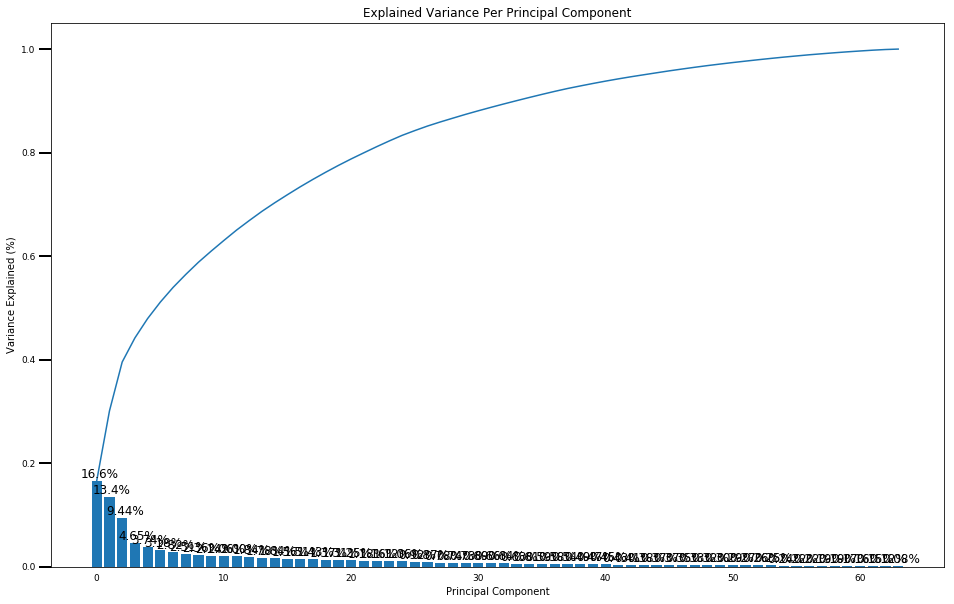

In [357]:
scree_plot_pca(pca)

In [358]:
# Re-implementation of  PCA while selecting the n_components
# Re-apply PCA to the data while selecting for number of components to retain.
pca = PCA(n_components=50)
azdias_pca = pca.fit_transform(azdias)

### Discussion 2.2: Perform Dimensionality Reduction

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding dimensionality reduction. How many principal components / transformed features are you retaining for the next step of the analysis?)

### Answer
Dimensionality reduction is basically transforming high dimensional space into low dimensional space, so that low dimensional space must keep the meaningful properties of the orginial dataset. We use Dimensionality reduction for very huge datasets in order to facilitate the meaningful parameters and by removing the undesired parameters whose removal don't affect the overall meaningful properties of the data. Here, I set number of components to 50 because at this value, I got explained variance more than 90% after 40 principal components. So, I selected n_components=50. From the graph, we can see that as we increases the number of components, the explained variance increase and then after some points, the graph curve reached to constant.To finding the features, I'll map each weight to their respected feature names, then sorting will be done on the basis of feature_weight. 



### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [359]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.
def print_component(pca, comp):
    data = pd.DataFrame({ 'features': azdias.columns ,'weight component_ '+str(comp): pca.components_[comp]})
    data['abs_W'] = data['weight component_ '+str(comp)].abs()  
    data = data.sort_values(by=['abs_W'],  ascending=False)
    data = data[['features', 'weight component_ '+str(comp)]]
    
    return data

In [360]:
data_1 = print_component(pca, 0)  #Map weight for first component
data_1

,features,weight component_ 0
46,MOBI_REGIO,-0.227101
52,PLZ8_ANTG3,0.225698
50,PLZ8_ANTG1,-0.224975
2,FINANZ_MINIMALIST,-0.222871
53,PLZ8_ANTG4,0.217704
36,KBA05_ANTG1,-0.214455
40,KBA05_GBZ,-0.213919
62,CAMEO_INTL_2015_Wealth,0.202706
57,ORTSGR_KLS9,0.198932
29,HH_EINKOMMEN_SCORE,0.197734


In [361]:
data_2 = print_component(pca, 1)  #Map weight for second component
data_2

,features,weight component_ 1
0,ALTERSKATEGORIE_GROB,0.252390
13,SEMIO_REL,-0.250251
60,PRAEGENDE_JUGENDJAHRE_Decade,-0.238172
3,FINANZ_SPARER,-0.228152
4,FINANZ_VORSORGER,0.226715
24,SEMIO_TRADV,-0.226134
17,SEMIO_ERL,0.225362
23,SEMIO_PFLICHT,-0.223686
6,FINANZ_UNAUFFAELLIGER,-0.222710
18,SEMIO_KULT,-0.215629


In [206]:
data_2 = print_component(pca, 2)  #Map weight for third component
data_2

,featurs,weight component_ 2
1,ANREDE_KZ,-0.370358
15,SEMIO_VERT,0.347417
22,SEMIO_KAEM,-0.338856
21,SEMIO_DOM,-0.315559
20,SEMIO_KRIT,-0.274618
11,SEMIO_SOZ,0.263640
12,SEMIO_FAM,0.251279
18,SEMIO_KULT,0.235800
19,SEMIO_RAT,-0.217014
5,FINANZ_ANLEGER,-0.186715


In [207]:
data_3 = print_component(pca, 3)  #Map weight for fourth component
data_3

,featurs,weight component_ 3
8,GREEN_AVANTGARDE,0.369158
45,KKK,-0.311001
42,EWDICHTE,0.274336
29,HH_EINKOMMEN_SCORE,-0.263649
41,BALLRAUM,-0.256857
57,ORTSGR_KLS9,0.253018
48,REGIOTYP,-0.245435
43,INNENSTADT,-0.233002
54,PLZ8_HHZ,0.183314
34,KONSUMNAEHE,-0.167167


### Discussion 2.3: Interpret Principal Components

(Double-click this cell and replace this text with your own text, reporting your observations from detailed investigation of the first few principal components generated. Can we interpret positive and negative values from them in a meaningful way?)

### Answer:
The first principal component is strongly correlated with three of the original variables.The principal components interpretation is based on finding which variables are most strongly correlated with each component, Here a correlation above 0.2 is considered as important.

First Component:
Strongest +ve feature: , PLZ8_ANTG3
Strongest -ve feature: MOBI_REGIO	

Second Component:
Strongest +ve feature: ALTERSKATEGORIE_GROB	,
Strongest -ve feature: SEMIO_REL	

Third Component:
Strongest +ve feature: SEMIO_VERT,
Strongest -ve feature: ANREDE_KZ		






## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [208]:

def get_kmeans_score(data, center):
    '''
    returns the kmeans score regarding SSE for points to centers
    INPUT:
        data - the dataset you want to fit kmeans to
        center - the number of centers you want (the k value)
    OUTPUT:
        score - the SSE score for the kmeans model fit to the data
    '''
    #instantiate kmeans
    kmeans = KMeans(n_clusters=center)

    # Then fit the model to your data using the fit method
    model = kmeans.fit(data)
    
    # Obtain a score related to the model fit
    
    score = np.abs(model.score(data))
    
    return score

In [209]:
scores = []

centers = np.arange(15, 30, 1)

for center in centers: 
    print(center)
    scores.append(get_kmeans_score(azdias_pca, center))

15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


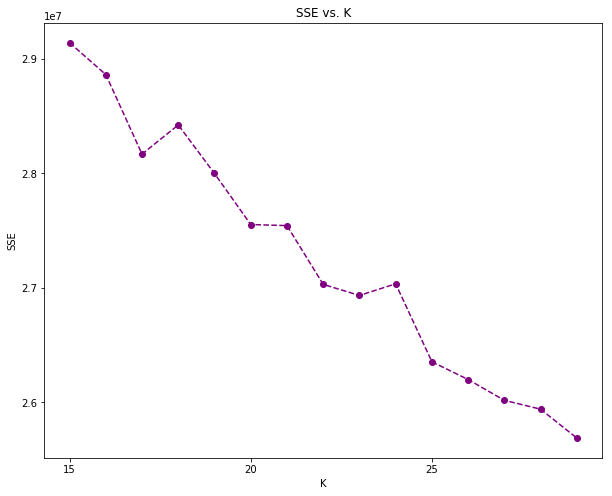

In [210]:
# Investigate the change in within-cluster distance across number of clusters.

plt.figure(figsize=(10, 8)) 
plt.plot(centers, scores, linestyle='--', marker='o', color='purple')
matplotlib.rc('xtick', labelsize=30)  
matplotlib.rc('ytick', labelsize=30)
plt.xlabel('K')
plt.ylabel('SSE')
plt.title('SSE vs. K')
plt.show()

In [211]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
kmeans = KMeans(n_clusters=25)
azdias_labels = kmeans.fit_predict(azdias_pca)

In [212]:
kls_azdias = pd.DataFrame( { 'cluster':pd.Series(azdias_labels).value_counts().index , \
                    '% of data': 100*pd.Series(azdias_labels).value_counts().values/len(azdias_labels)})
kls_azdias['data'] = 'population'

In [213]:
kls_azdias.head()

,cluster,% of data,data
0,5,6.015285,population
1,20,5.883370,population
2,3,5.838323,population
3,6,5.668719,population
4,18,5.651939,population


In [214]:
kls_azdias.shape

(25, 3)

### Discussion 3.1: Apply Clustering to General Population

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding clustering. Into how many clusters have you decided to segment the population?)
### Answer:
This is the most time-consuming section. Here, I have applied the significant number of clusters =25. In the above graph, as we can see that there is no clear elbow formation. The graph is fluctuating and SSE (Sum of squared errors) kept on decreasing as number of clusters increase.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [215]:
# Loading the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=";")
print(customers)

        AGER_TYP  ALTERSKATEGORIE_GROB  ANREDE_KZ  CJT_GESAMTTYP  \
0              2                     4          1            5.0   
1             -1                     4          1            NaN   
2             -1                     4          2            2.0   
3              1                     4          1            2.0   
4             -1                     3          1            6.0   
5              1                     3          1            4.0   
6              2                     4          1            2.0   
7              1                     4          1            2.0   
8              2                     4          2            1.0   
9              1                     3          1            3.0   
10            -1                     3          2            5.0   
11             1                     4          1            3.0   
12            -1                     4          1            5.0   
13            -1                     3          

In [216]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.
customers = clean_data_1(customers)
customers


,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,PRAEGENDE_JUGENDJAHRE_Decade,PRAEGENDE_JUGENDJAHRE_Movement,CAMEO_INTL_2015_Wealth,CAMEO_INTL_2015_Lifestage
0,4.0,1.0,5.0,1.0,5.0,1.0,2.0,2.0,1,1.0,...,0.0,5.0,5.0,1.0,2.0,1.0,30.0,30.0,1.0,3.0
2,4.0,2.0,5.0,1.0,5.0,1.0,4.0,4.0,1,2.0,...,1.0,3.0,2.0,3.0,5.0,3.0,30.0,30.0,3.0,4.0
3,4.0,1.0,5.0,1.0,5.0,2.0,1.0,2.0,0,2.0,...,0.0,3.0,4.0,1.0,3.0,1.0,20.0,20.0,2.0,4.0
4,3.0,1.0,3.0,1.0,4.0,4.0,5.0,2.0,0,3.0,...,1.0,3.0,3.0,3.0,5.0,1.0,40.0,40.0,4.0,1.0
5,3.0,1.0,5.0,1.0,5.0,1.0,2.0,3.0,1,3.0,...,1.0,5.0,5.0,3.0,7.0,5.0,30.0,30.0,3.0,4.0
6,4.0,1.0,5.0,1.0,5.0,1.0,1.0,2.0,1,2.0,...,0.0,5.0,5.0,2.0,3.0,2.0,30.0,30.0,2.0,3.0
7,4.0,1.0,5.0,1.0,5.0,1.0,2.0,2.0,1,1.0,...,1.0,3.0,3.0,3.0,4.0,3.0,30.0,30.0,1.0,5.0
8,4.0,2.0,2.0,2.0,5.0,1.0,1.0,5.0,0,2.0,...,1.0,5.0,4.0,3.0,8.0,3.0,20.0,20.0,5.0,5.0
9,3.0,1.0,5.0,2.0,4.0,1.0,3.0,1.0,1,3.0,...,0.0,5.0,5.0,3.0,6.0,4.0,50.0,50.0,1.0,5.0
11,4.0,1.0,5.0,1.0,5.0,1.0,3.0,2.0,1,1.0,...,0.0,3.0,3.0,2.0,5.0,1.0,30.0,30.0,1.0,4.0


In [217]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 136159 entries, 0 to 191651
Data columns (total 64 columns):
ALTERSKATEGORIE_GROB              135947 non-null float64
ANREDE_KZ                         136159 non-null float64
FINANZ_MINIMALIST                 136159 non-null float64
FINANZ_SPARER                     136159 non-null float64
FINANZ_VORSORGER                  136159 non-null float64
FINANZ_ANLEGER                    136159 non-null float64
FINANZ_UNAUFFAELLIGER             136159 non-null float64
FINANZ_HAUSBAUER                  136159 non-null float64
GREEN_AVANTGARDE                  136159 non-null int64
HEALTH_TYP                        134133 non-null float64
RETOURTYP_BK_S                    136159 non-null float64
SEMIO_SOZ                         136159 non-null float64
SEMIO_FAM                         136159 non-null float64
SEMIO_REL                         136159 non-null float64
SEMIO_MAT                         136159 non-null float64
SEMIO_VERT           

In [218]:
customers = pd.DataFrame( Imp.fit_transform(customers.values), columns=customers.columns)


In [219]:
customers = pd.DataFrame(scaler.fit_transform(customers.values), columns=customers.columns)


In [220]:
customers.describe()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,PRAEGENDE_JUGENDJAHRE_Decade,PRAEGENDE_JUGENDJAHRE_Movement,CAMEO_INTL_2015_Wealth,CAMEO_INTL_2015_Lifestage
count,1.361590e+05,1.361590e+05,1.361590e+05,1.361590e+05,1.361590e+05,1.361590e+05,1.361590e+05,1.361590e+05,1.361590e+05,1.361590e+05,...,1.361590e+05,1.361590e+05,1.361590e+05,1.361590e+05,1.361590e+05,1.361590e+05,1.361590e+05,1.361590e+05,1.361590e+05,1.361590e+05
mean,3.945169e-17,-2.080346e-16,2.560446e-16,4.133035e-17,-2.532005e-16,-3.966043e-17,-4.226967e-17,-1.529014e-17,4.070413e-18,1.706442e-17,...,2.296130e-17,1.241998e-17,-6.199552e-17,-1.502922e-16,1.963191e-16,-9.268017e-17,2.617067e-16,2.617067e-16,1.085443e-17,-1.452824e-16
std,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,...,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00
min,-3.448873e+00,-7.012451e-01,-3.220937e+00,-5.116613e-01,-4.267022e+00,-5.976355e-01,-8.762897e-01,-1.324821e+00,-1.002625e+00,-1.260326e+00,...,-8.419935e-01,-2.822433e+00,-2.604708e+00,-1.811371e+00,-1.908708e+00,-1.337667e+00,-1.614351e+00,-1.614351e+00,-1.132668e+00,-1.773959e+00
25%,-6.841745e-01,-7.012451e-01,-2.663476e-01,-5.116613e-01,-6.835478e-01,-5.976355e-01,-8.762897e-01,-5.638771e-01,-1.002625e+00,-1.260326e+00,...,-8.419935e-01,-6.765866e-01,-6.160214e-01,-8.179269e-01,-5.158378e-01,-6.323174e-01,-6.113282e-01,-6.113282e-01,-1.132668e+00,-1.026403e+00
50%,6.981747e-01,-7.012451e-01,7.185156e-01,-5.116613e-01,5.109436e-01,-5.976355e-01,1.614372e-01,-5.638771e-01,9.973815e-01,4.399829e-02,...,-8.419935e-01,-6.765866e-01,3.783222e-01,1.755176e-01,-5.154764e-02,7.303243e-02,-6.113282e-01,-6.113282e-01,-4.212880e-01,4.687080e-01
75%,6.981747e-01,1.426035e+00,7.185156e-01,7.026469e-01,5.109436e-01,4.049822e-01,1.614372e-01,9.580104e-01,9.973815e-01,1.348323e+00,...,7.301657e-01,3.963369e-01,3.783222e-01,1.168962e+00,8.770328e-01,7.783823e-01,3.916944e-01,3.916944e-01,1.001473e+00,4.687080e-01
max,6.981747e-01,1.426035e+00,7.185156e-01,4.345571e+00,5.109436e-01,3.412835e+00,3.274618e+00,1.718954e+00,9.973815e-01,1.348323e+00,...,2.302325e+00,1.469260e+00,1.372666e+00,2.162407e+00,1.805613e+00,1.483732e+00,2.397740e+00,2.397740e+00,1.712853e+00,1.216264e+00


In [221]:
customers.head(5)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,PRAEGENDE_JUGENDJAHRE_Decade,PRAEGENDE_JUGENDJAHRE_Movement,CAMEO_INTL_2015_Wealth,CAMEO_INTL_2015_Lifestage
0,0.698175,-0.701245,0.718516,-0.511661,0.510944,-0.597636,0.161437,-0.563877,0.997381,-1.260326,...,-0.841994,1.469260,1.372666,-1.811371,-1.444418,-1.337667,-0.611328,-0.611328,-1.132668,-0.278848
1,0.698175,1.426035,0.718516,-0.511661,0.510944,-0.597636,2.236891,0.958010,0.997381,0.043998,...,0.730166,-0.676587,-1.610365,0.175518,-0.051548,0.073032,-0.611328,-0.611328,0.290092,0.468708
2,0.698175,-0.701245,0.718516,-0.511661,0.510944,0.404982,-0.876290,-0.563877,-1.002625,0.043998,...,-0.841994,-0.676587,0.378322,-1.811371,-0.980128,-1.337667,-1.614351,-1.614351,-0.421288,0.468708
3,-0.684174,-0.701245,-1.251211,-0.511661,-0.683548,2.410218,3.274618,-0.563877,-1.002625,1.348323,...,0.730166,-0.676587,-0.616021,0.175518,-0.051548,-1.337667,0.391694,0.391694,1.001473,-1.773959
4,-0.684174,-0.701245,0.718516,-0.511661,0.510944,-0.597636,0.161437,0.197067,0.997381,1.348323,...,0.730166,1.469260,1.372666,0.175518,0.877033,1.483732,-0.611328,-0.611328,0.290092,0.468708


In [222]:
customers.shape

(136159, 64)

In [223]:
customers_pca = pca.fit_transform(customers)

In [224]:
customers_labels = kmeans.predict(customers_pca)

In [225]:
kls_customers = pd.DataFrame( { 'cluster':pd.Series(customers_labels).value_counts().index , \
        '% of data': 100*pd.Series(customers_labels).value_counts().values/len(customers_labels)})
kls_customers['data'] = 'customer'

In [226]:
kls_customers.head(5)

,cluster,% of data,data
0,6,15.708840,customer
1,9,7.143854,customer
2,7,6.182478,customer
3,17,6.093611,customer
4,12,5.804244,customer


### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

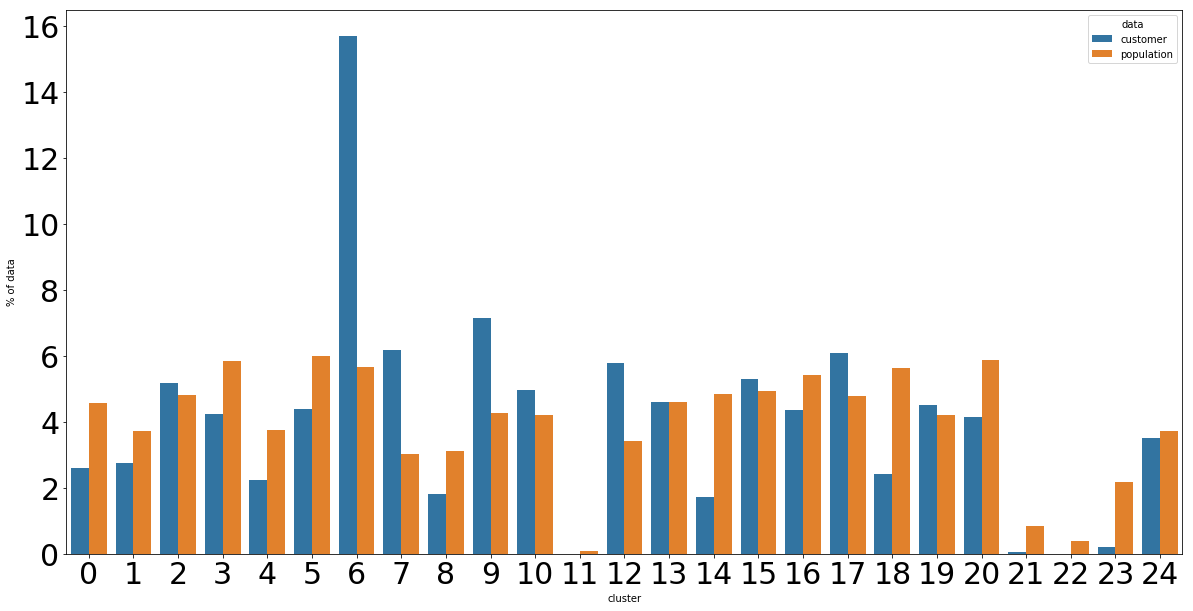

In [227]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
plt.figure(figsize=(20, 10))
sns.barplot(x="cluster", y="% of data", hue="data",
            data=pd.concat([kls_customers, kls_azdias]))
plt.show()


In [237]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?
data_cus_1 = scaler.inverse_transform(pca.inverse_transform(customers_pca[\
                                        np.where(customers_labels == 6)])).round()
data_1 = pd.DataFrame(data=data_cus_1, index=np.array(range(0, data_cus_1.shape[0])),
                    columns=customers.columns)
data_1.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,PRAEGENDE_JUGENDJAHRE_Decade,PRAEGENDE_JUGENDJAHRE_Movement,CAMEO_INTL_2015_Wealth,CAMEO_INTL_2015_Lifestage
0,4.0,1.0,5.0,1.0,5.0,1.0,2.0,2.0,1.0,1.0,...,0.0,5.0,5.0,1.0,2.0,1.0,30.0,30.0,1.0,3.0
1,4.0,1.0,5.0,1.0,5.0,1.0,1.0,2.0,1.0,2.0,...,0.0,5.0,5.0,2.0,3.0,2.0,30.0,30.0,2.0,3.0
2,4.0,1.0,5.0,1.0,5.0,1.0,2.0,2.0,1.0,1.0,...,1.0,3.0,3.0,3.0,4.0,3.0,30.0,30.0,1.0,5.0
3,4.0,1.0,5.0,1.0,5.0,1.0,3.0,2.0,1.0,1.0,...,0.0,3.0,4.0,2.0,4.0,1.0,29.0,29.0,1.0,4.0
4,3.0,1.0,5.0,1.0,5.0,1.0,3.0,2.0,1.0,1.0,...,0.0,3.0,4.0,3.0,4.0,3.0,30.0,30.0,1.0,5.0


In [236]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?
data_cus_1 = scaler.inverse_transform(pca.inverse_transform(customers_pca[\
                                        np.where(customers_labels == 9)])).round()
data_1 = pd.DataFrame(data=data_cus_1, index=np.array(range(0, data_cus_1.shape[0])),
                    columns=customers.columns)
data_1.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,PRAEGENDE_JUGENDJAHRE_Decade,PRAEGENDE_JUGENDJAHRE_Movement,CAMEO_INTL_2015_Wealth,CAMEO_INTL_2015_Lifestage
0,4.0,1.0,5.0,1.0,5.0,2.0,1.0,2.0,0.0,2.0,...,-0.0,3.0,4.0,1.0,2.0,1.0,20.0,20.0,2.0,4.0
1,4.0,1.0,3.0,1.0,5.0,2.0,1.0,4.0,0.0,2.0,...,1.0,4.0,3.0,1.0,3.0,1.0,29.0,29.0,4.0,3.0
2,4.0,1.0,5.0,1.0,5.0,1.0,2.0,3.0,1.0,3.0,...,-0.0,4.0,5.0,3.0,3.0,5.0,31.0,31.0,2.0,5.0
3,4.0,1.0,5.0,1.0,5.0,2.0,1.0,3.0,0.0,2.0,...,0.0,4.0,4.0,1.0,0.0,1.0,39.0,39.0,5.0,4.0
4,4.0,1.0,5.0,1.0,5.0,1.0,1.0,3.0,-0.0,1.0,...,-0.0,3.0,4.0,2.0,2.0,1.0,30.0,30.0,2.0,4.0


In [239]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?
data_cus_2 = scaler.inverse_transform(pca.inverse_transform(customers_pca[\
                                        np.where(customers_labels == 2)])).round()
data_2 = pd.DataFrame(data=data_cus_2, index=np.array(range(0, data_cus_2.shape[0])),
                    columns=customers.columns)
data_2.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,PRAEGENDE_JUGENDJAHRE_Decade,PRAEGENDE_JUGENDJAHRE_Movement,CAMEO_INTL_2015_Wealth,CAMEO_INTL_2015_Lifestage
0,4.0,1.0,5.0,1.0,5.0,1.0,1.0,2.0,1.0,2.0,...,1.0,3.0,3.0,3.0,5.0,4.0,30.0,30.0,3.0,5.0
1,4.0,1.0,5.0,1.0,5.0,1.0,1.0,2.0,1.0,2.0,...,1.0,5.0,5.0,3.0,6.0,5.0,40.0,40.0,5.0,4.0
2,4.0,1.0,5.0,1.0,5.0,1.0,1.0,3.0,1.0,2.0,...,2.0,4.0,3.0,4.0,7.0,5.0,30.0,30.0,5.0,4.0
3,4.0,1.0,4.0,1.0,5.0,1.0,2.0,5.0,0.0,2.0,...,1.0,3.0,3.0,3.0,6.0,4.0,30.0,30.0,4.0,1.0
4,4.0,1.0,5.0,1.0,5.0,1.0,2.0,3.0,1.0,3.0,...,1.0,4.0,3.0,3.0,7.0,2.0,30.0,30.0,4.0,1.0


In [240]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?
data_up_1 = scaler.inverse_transform(pca.inverse_transform(azdias_pca[\
                                        np.where(azdias_labels == 23)])).round()
data_ag_1 = pd.DataFrame(data=data_up_1, index=np.array(range(0, data_up_1.shape[0])),
                       columns=azdias.columns)
data_ag_1.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,NEW_OST_WEST_KZ,PRAEGENDE_JUGENDJAHRE_Decade,PRAEGENDE_JUGENDJAHRE_Movement,CAMEO_INTL_2015_Wealth,CAMEO_INTL_2015_Lifestage
0,4.0,1.0,5.0,1.0,5.0,0.0,2.0,2.0,1.0,3.0,...,0.0,2.0,3.0,1.0,5.0,-0.0,44.0,44.0,2.0,3.0
1,5.0,2.0,3.0,0.0,6.0,0.0,2.0,5.0,1.0,1.0,...,-0.0,4.0,5.0,1.0,4.0,1.0,31.0,31.0,0.0,7.0
2,5.0,1.0,4.0,1.0,5.0,1.0,1.0,3.0,1.0,1.0,...,-0.0,2.0,4.0,1.0,3.0,2.0,24.0,24.0,1.0,5.0
3,4.0,1.0,4.0,1.0,5.0,1.0,1.0,3.0,1.0,1.0,...,-1.0,4.0,5.0,2.0,4.0,1.0,40.0,40.0,1.0,4.0
4,5.0,1.0,4.0,-0.0,6.0,-0.0,1.0,5.0,0.0,1.0,...,1.0,4.0,4.0,1.0,4.0,-0.0,27.0,27.0,1.0,4.0


In [231]:
data_up_2 = scaler.inverse_transform(pca.inverse_transform(azdias_pca[\
                                        np.where(azdias_labels == 12)])).round()
data_ag_2 = pd.DataFrame(data=data_up_2, index=np.array(range(0, data_up_2.shape[0])),
                       columns=azdias.columns)
#data_up_2.shape
data_ag_2.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,NEW_OST_WEST_KZ,PRAEGENDE_JUGENDJAHRE_Decade,PRAEGENDE_JUGENDJAHRE_Movement,CAMEO_INTL_2015_Wealth,CAMEO_INTL_2015_Lifestage
0,4.0,2.0,3.0,1.0,5.0,2.0,2.0,5.0,-1.0,3.0,...,1.0,4.0,3.0,2.0,5.0,4.0,32.0,32.0,3.0,2.0
1,4.0,2.0,3.0,1.0,5.0,2.0,1.0,5.0,-0.0,1.0,...,2.0,4.0,3.0,3.0,7.0,4.0,27.0,27.0,3.0,3.0
2,5.0,2.0,2.0,1.0,5.0,2.0,2.0,5.0,-0.0,2.0,...,1.0,3.0,2.0,2.0,6.0,3.0,20.0,20.0,4.0,4.0
3,3.0,2.0,3.0,1.0,5.0,2.0,2.0,5.0,1.0,2.0,...,1.0,3.0,3.0,3.0,6.0,4.0,30.0,30.0,4.0,2.0
4,3.0,2.0,2.0,3.0,3.0,2.0,4.0,4.0,0.0,2.0,...,1.0,4.0,4.0,3.0,6.0,3.0,50.0,50.0,5.0,3.0


### Discussion 3.3: Compare Customer Data to Demographics Data

(Double-click this cell and replace this text with your own text, reporting findings and conclusions from the clustering analysis. Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?)

### Answer:
From the graph, we can clearly see that there is a good complement between general population and customers at these clusters:2,13,15,19 and 24 whereas the clusters 1, 16,17,19 are slightly different from each other. There ia a huge difference between these clusters:6, 7, 9, 14 and 18. This information for mail-order company will be helpul in decision-making process. I believe that the removed 7 columns and many other rows rows in our dataset, which may contain meaningful information. If we kept those removed features, I think our results will be much better and a very excellent complement between the general population and the customers data.
In the popular segments, social status makes sense because estimated household net income plays a significant role in customers segmentation analysis for the mail-order company whereas membership in environmental sustainability is less relative and might be plays role in ecofriendly industrial packaging system.

Under the unpopular segments, Nationality and insurance typology are not so related to mail-order company.

We can compare NaN for customer and population data. For customers, it is around 30%. We can apply differnt types of techniques for handling the missing data. (https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3668100/)

In the future work, I would like to apply the differnt algorithms of unsupervised learning and then make the comaprison between the results. I would be intersting by applying different encoders, feature scaling, techniques, cut-off, number of clusters, feature optimization and so on and then compare the results and effects on the unsupervised machine learning techniques.





> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.